In [16]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

# target
TARGET = "exam_score"

# Read Data
train_df = pd.read_csv("./data/Playground-S6-E1/train.csv")
test_df = pd.read_csv("./data/Playground-S6-E1/test.csv")

# Check Data
train_df.head()

sns.set_palette("Set3")



In [17]:
# Checking for null values
train_df.isnull().sum()

id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

In [18]:
# Checking for duplicate values
train_df.duplicated().sum()

np.int64(0)

In [19]:
# Unique values
train_df.nunique()

id                  630000
age                      8
gender                   3
course                   7
study_hours            792
class_attendance       617
internet_access          2
sleep_hours             66
sleep_quality            3
study_method             5
facility_rating          3
exam_difficulty          3
exam_score             805
dtype: int64

In [20]:
train_df.describe()

,id,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,7.072758,62.506672
std,181865.479132,2.260238,2.359880,17.430098,1.744811,18.916884
min,0.000000,17.000000,0.080000,40.600000,4.100000,19.599000
25%,157499.750000,19.000000,1.970000,57.000000,5.600000,48.800000
50%,314999.500000,21.000000,4.000000,72.600000,7.100000,62.600000
75%,472499.250000,23.000000,6.050000,87.200000,8.600000,76.300000
max,629999.000000,24.000000,7.910000,99.400000,9.900000,100.000000


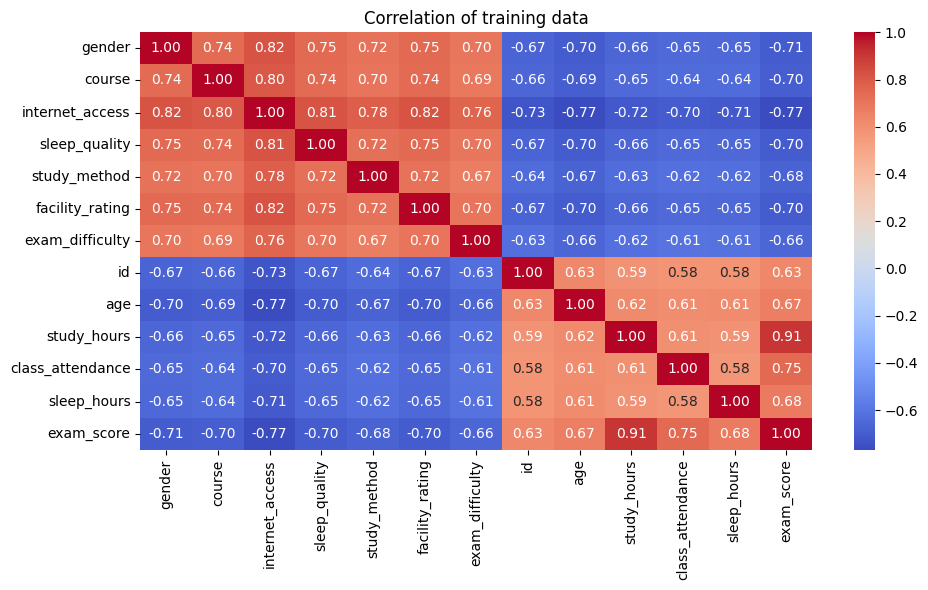

In [21]:
from sklearn.preprocessing import OneHotEncoder

# HeatMap to view correlation among variables
train_obj_cols = train_df.select_dtypes(include="object")
train_num_cols = train_df.select_dtypes(include="number")

train_ohe = pd.concat([train_obj_cols, train_num_cols], axis=0)

for col in train_ohe.columns:
    le = LabelEncoder()
    train_ohe[col] = le.fit_transform(train_ohe[col])
    

plt.figure(figsize=(10, 6))
sns.heatmap(train_ohe.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of training data")
plt.tight_layout()
plt.show()

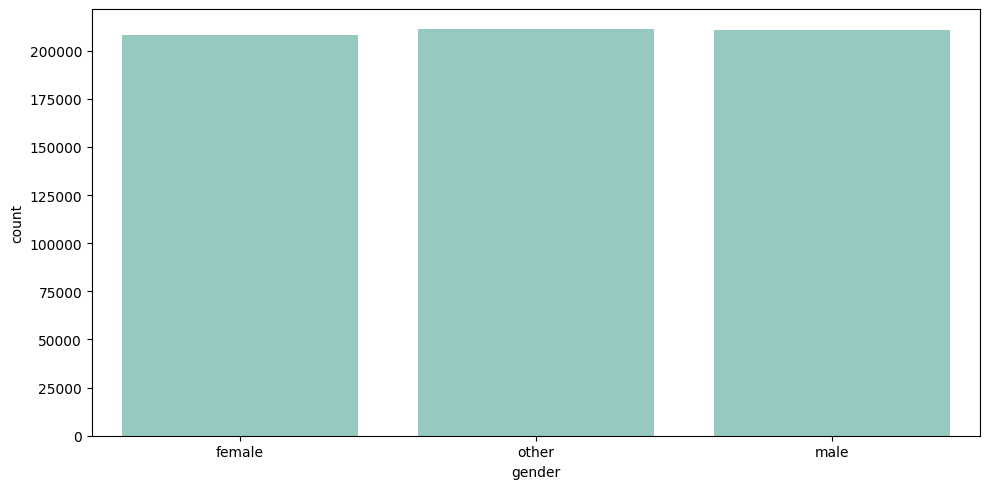

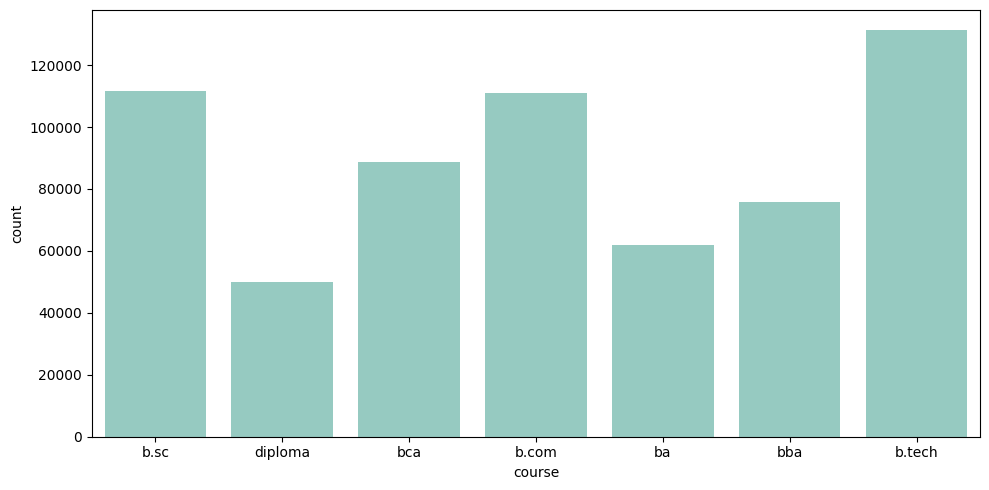

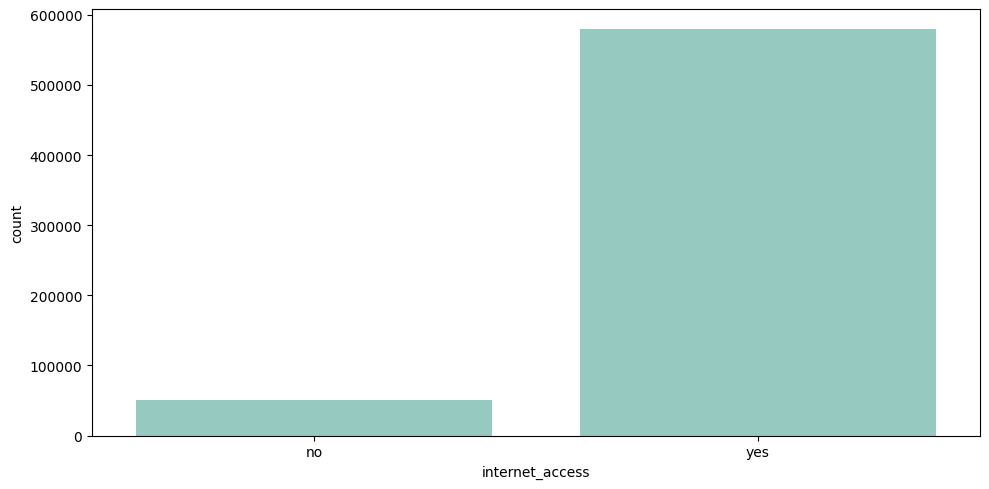

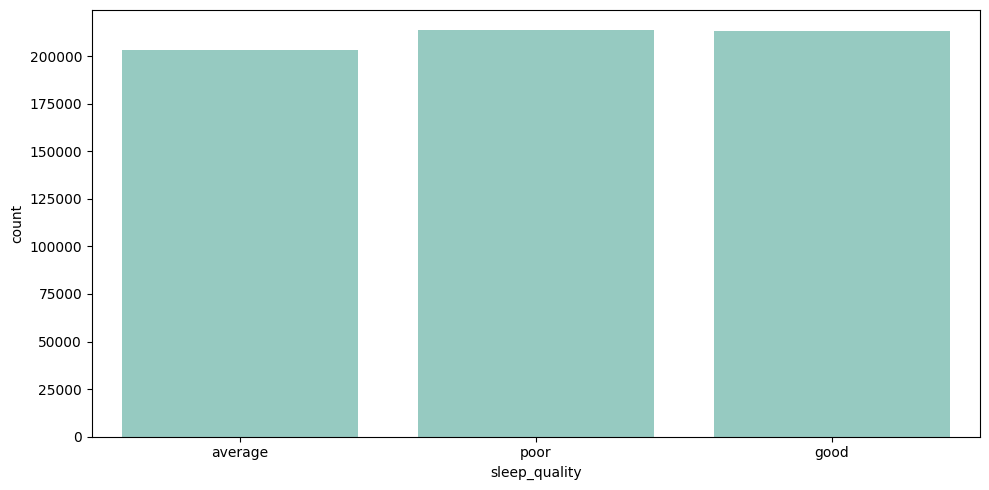

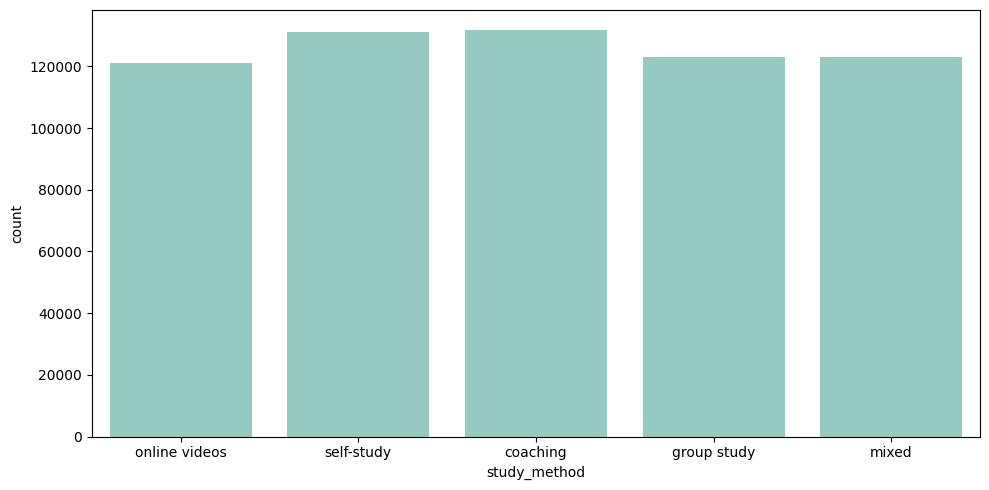

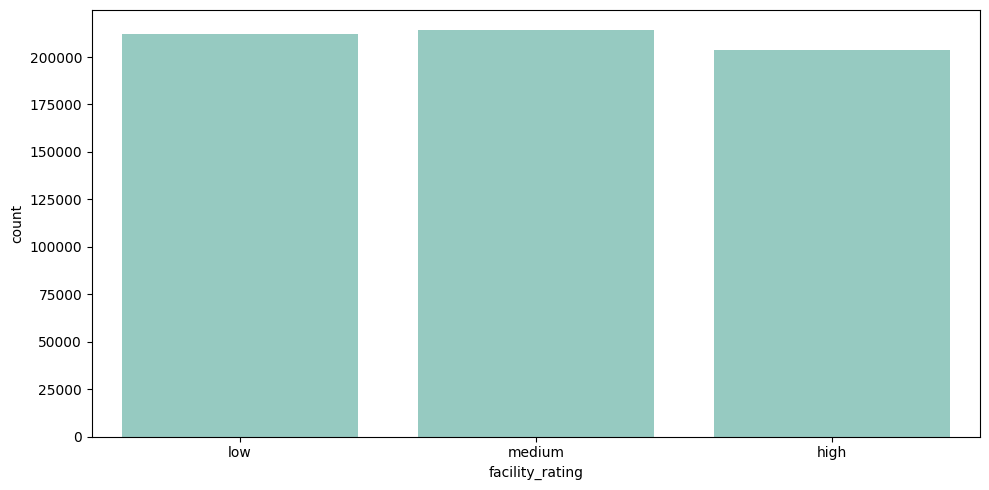

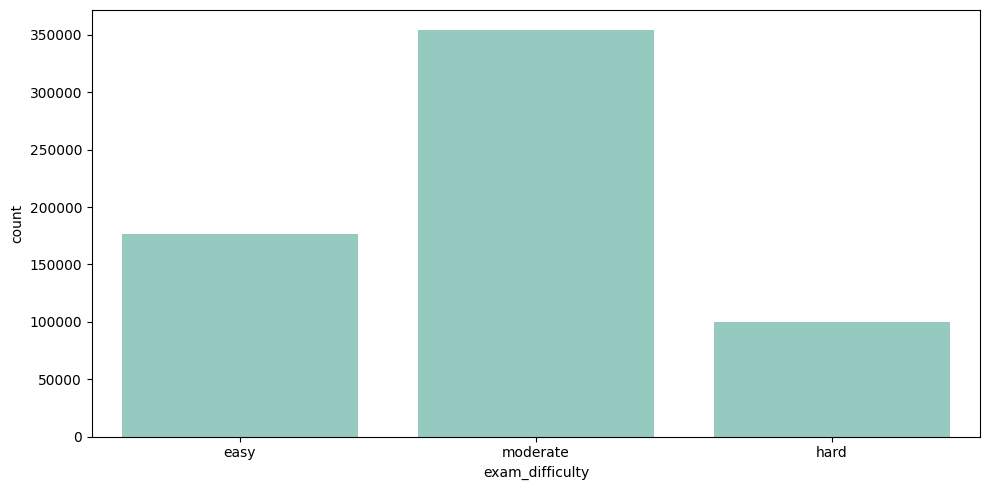

In [22]:
# EDA

for col in train_df.select_dtypes(include="object").columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=train_df[col])
    plt.tight_layout()
    plt.show()

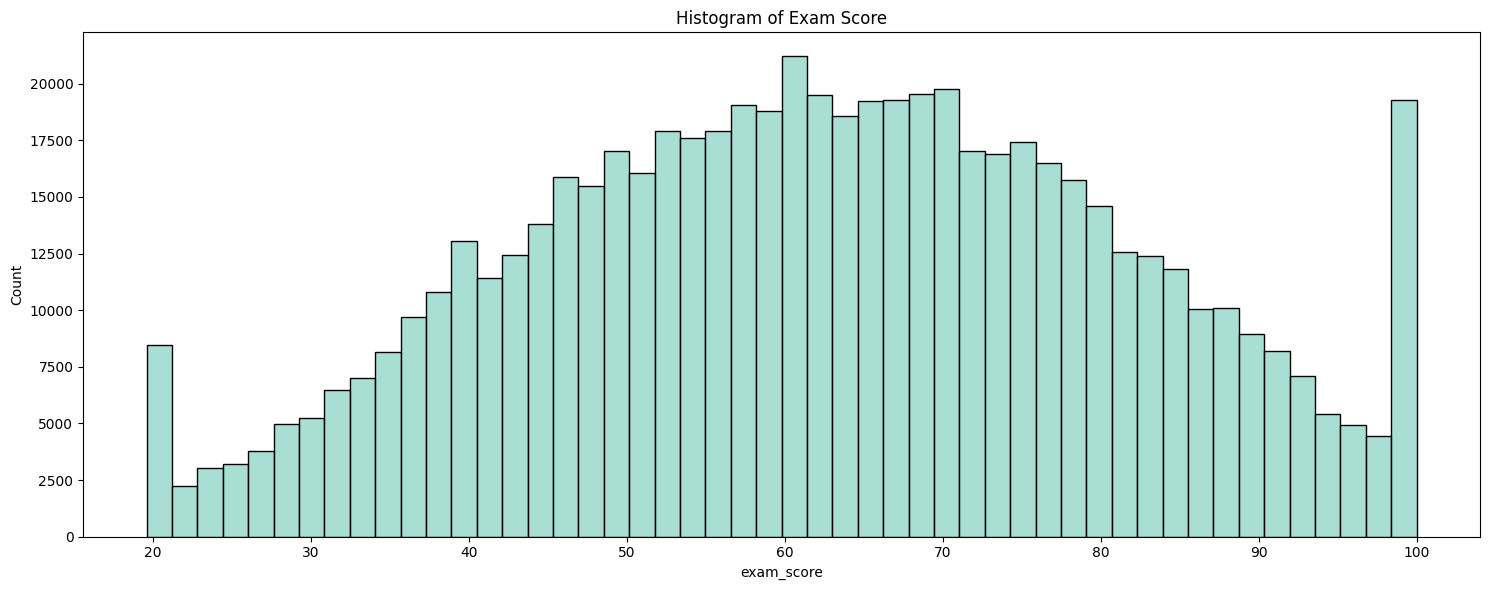

In [23]:
plt.figure(figsize=(15, 6))
sns.histplot(x="exam_score", data=train_df, bins=50)
plt.title("Histogram of Exam Score")
plt.tight_layout()
plt.show()

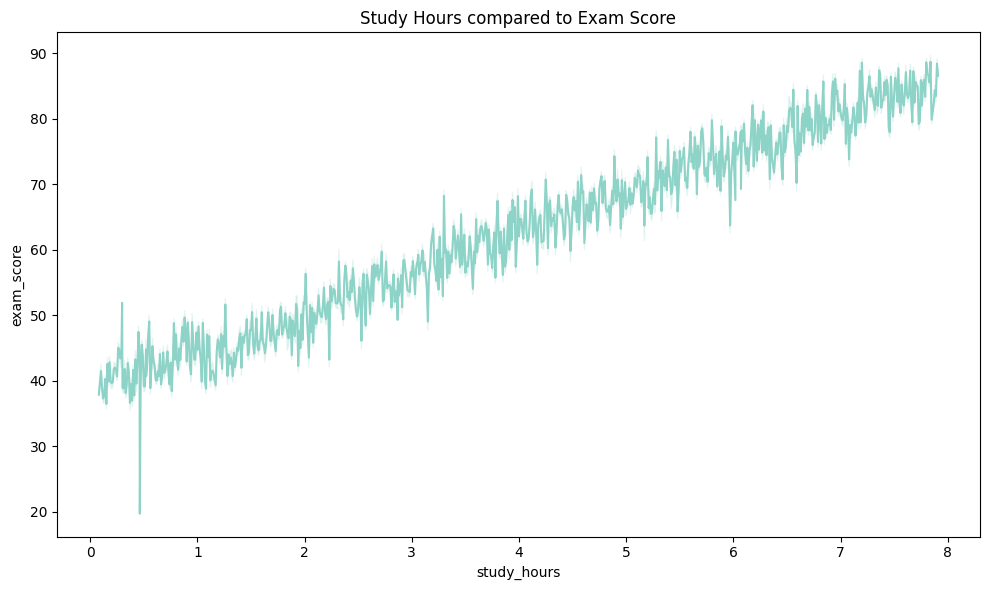

In [24]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="study_hours", y="exam_score", data=train_df)
plt.title("Study Hours compared to Exam Score")
plt.tight_layout()
plt.show()

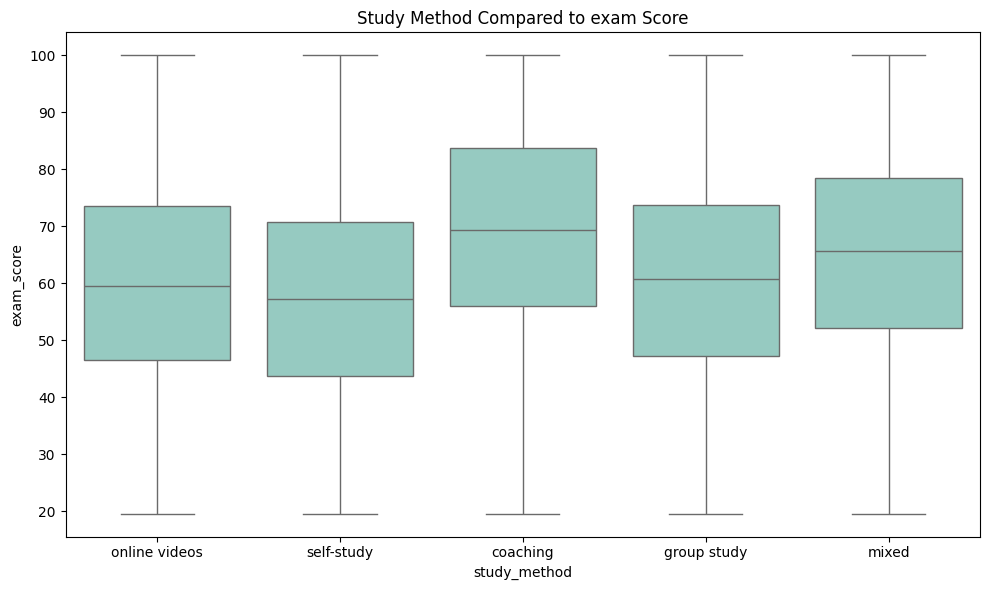

In [25]:
# study method compared to exam score

plt.figure(figsize=(10, 6))
sns.boxplot(x="study_method", y="exam_score", data=train_df)
plt.title("Study Method Compared to exam Score")
plt.tight_layout()
plt.show()

In [ ]:
cat_cols = train_df.select_dtypes(include="object").columns

# 전처리를 위해 Train/Test 합치기
# Target 컬럼(exam_score)은 제외하고 합친다.
all_df = pd.concat([train_df.drop(columns=[TARGET]), test_df], axis=0)

# LabelEncoder 적용
le = LabelEncoder()
for col in cat_cols:
    # astype(str)은 결측치나 숫자 혼용 등으로 인한 에러 방지용
    all_df[col] = le.fit_transform(all_df[col].astype(str))

# 다시 Train / Test로 분리
X_train_full = all_df[:len(train_df)]
X_test_final = all_df[len(train_df):]

# Y값 준비
y_train_full = train_df[TARGET]

In [29]:
X_train_full.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,0,21,0,1,7.91,98.8,0,4.9,0,3,1,0
1,1,18,2,6,4.95,94.8,1,4.7,2,4,2,2
2,2,20,0,1,4.68,92.6,1,5.8,2,0,0,2
3,3,19,1,1,2.00,49.5,1,8.3,0,1,0,2
4,4,23,1,5,7.65,86.9,1,9.6,1,4,0,0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.2)

In [31]:
xgb_params = {
    "n_estimators": 10000,
    "learning_rate": 0.03,
    "max_depth": 4,
    "min_child_weight": 3,
    "subsample": 0.85,
    "colsample_bytree": 0.85,
    "max_bin": 2048,
    "reg_alpha": 0.5,
    "reg_lambda": 1.5,
    "eval_metric": "rmse",
}

best_model = xgb.XGBRegressor(**xgb_params)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse}")

RMSE: 8.69031361381333


In [32]:
predictions = best_model.predict(X_test_final)

submission = pd.DataFrame({
    'id': X_test_final["id"],
    'exam_score': predictions,
})

submission

,id,exam_score
0,630000,68.795082
1,630001,67.393181
2,630002,90.838928
3,630003,57.579601
4,630004,47.957764
...,...,...
269995,899995,64.038788
269996,899996,41.226803
269997,899997,88.880157
269998,899998,52.300587


In [33]:
submission.to_csv("./data/Playground-S6-E1/submission.csv", index=False)